In [2]:
from pendulum_forces import MagneticPendulumInvSpherical, MagneticPendulumXY
import numpy as np
import sympy as sp
from scipy.constants import g as g_value
from scipy.integrate import solve_ivp
from scipy.cluster.vq import kmeans2
from matplotlib import pyplot as plt
%matplotlib widget

In [5]:
# P = MagneticPendulumInvSpherical(4)
P = MagneticPendulumXY(4)

const1_subs = {
    'm': 1,
    'g': g_value,
    'L': g_value,
    'R': 2,
    'h': 0.5,
    'b': 0.1,   
}
magnet_strength = 10

magnet_polarity_vals = dict((p.name, magnet_strength) for p in P.polarity_list)
constant_subs = const1_subs | magnet_polarity_vals

bob = P.create_bob(constant_subs=constant_subs)

In [7]:
ddt = P._get_ddt(bob=bob)


In [99]:
# setup
resolution=500

x_min = -4
x_max = 4
y_min = -4
y_max = 4

## go
z_const = -constant_subs['L']
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)

starting_x_y_pairs = np.array(np.meshgrid(x, y)).T.reshape(-1,2)
starting_x_y_pairs.shape


(250000, 2)

In [100]:
from tqdm.notebook import tqdm
t_max = 100
dt = 0.01
t_vals = np.arange(0, t_max, dt)

In [101]:
final_positions_array = np.empty_like(starting_x_y_pairs)
np_eps = np.finfo(np.float64).eps

t_vals = np.arange(0, t_max, dt)

for i, (x_start, y_start) in enumerate(tqdm(starting_x_y_pairs)):

    starting_pos = np.array([x_start, y_start, z_const, 0,0,0])
    final_positions_array[i] = solve_ivp(ddt, (0, t_max), starting_pos, t_eval=t_vals, method='RK45').y[0:2, -1]    

  0%|          | 0/250000 [00:00<?, ?it/s]

In [102]:
# from plotting import *
# trajectory = P.path_to_trajectory(solve_ivp(ddt, (0, t_max), starting_pos, t_eval=t_vals, method='RK45').y)
# plot_trajectory(trajectory, magnet_positions=magnet_positions, L=8)

In [103]:
final_positions_array.shape

(250000, 2)

In [104]:
def col_map(x):
    if x == 0:
        return "lime"
    if x == 1:
        return 'red'
    if x == 2:
        return 'blue'
    if x == 3:
        return 'yellow'
    else:
        return 'black'

In [105]:
magnet_positions = []
for magnet_pos in P.magnet_positions_C:
    magnet_pos = magnet_pos.subs(constant_subs)
    magnet_positions.append([magnet_pos.dot(P.coordsystem.C.i), magnet_pos.dot(P.coordsystem.C.j)])
magnet_positions

equilibria_regions = np.array(magnet_positions + [[0,0]], dtype=np.float64)
equilibria_regions

array([[ 2.,  0.],
       [ 0.,  2.],
       [-2.,  0.],
       [ 0., -2.],
       [ 0.,  0.]])

/tmp/ipykernel_499053/3789946861.py:2: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  clusters = kmeans2(final_positions_array, k=equilibria_regions)


(-4.0, 4.0)

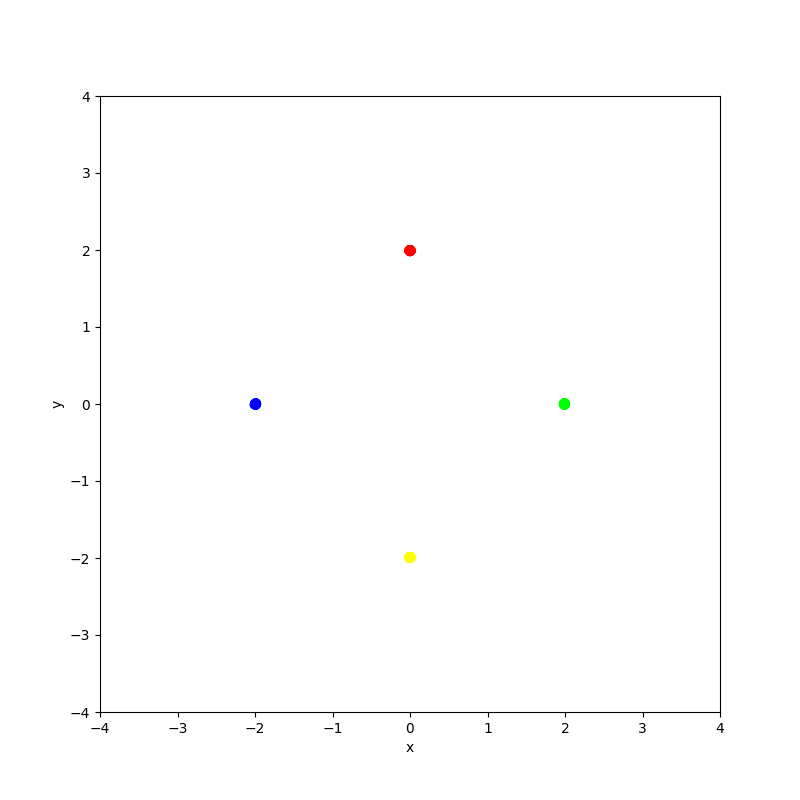

In [107]:
# wld like to change it but this does do colour for now...
clusters = kmeans2(final_positions_array, k=equilibria_regions)
groups = clusters[1]
## end

xs, ys = final_positions_array[:, 0], final_positions_array[:, 1]

ax = plt.figure(figsize=(8, 8)).add_subplot()
clist = [col_map(x) for x in groups]
ax.scatter(xs, ys, c=clist)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)


In [108]:
final_positions_array[np.where((groups == 3))]

array([[ 8.54712682e-05, -2.00053824e+00],
       [-6.39117533e-04, -1.98881137e+00],
       [ 5.47864063e-03, -1.99435989e+00],
       ...,
       [-2.51486179e-03, -1.99724692e+00],
       [-2.52893898e-03, -1.98990539e+00],
       [-2.15295091e-03, -1.99679376e+00]])

In [109]:
radius_array = starting_x_y_pairs[:, 0]**2 + starting_x_y_pairs[:, 1]**2
starting_x_y_pairs[np.where((groups == 0) & (radius_array < 2) & (radius_array > 1))]

array([[-0.98597194, -1.00200401],
       [-0.98597194,  1.00200401],
       [-0.96993988, -0.98597194],
       ...,
       [ 1.40280561,  0.13627255],
       [ 1.40280561,  0.15230461],
       [ 1.40280561,  0.16833667]])

In [110]:
starting_x_y_pairs

array([[-4.        , -4.        ],
       [-4.        , -3.98396794],
       [-4.        , -3.96793587],
       ...,
       [ 4.        ,  3.96793587],
       [ 4.        ,  3.98396794],
       [ 4.        ,  4.        ]])

/tmp/ipykernel_499053/1563649256.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


Text(0, 0.5, 'y')

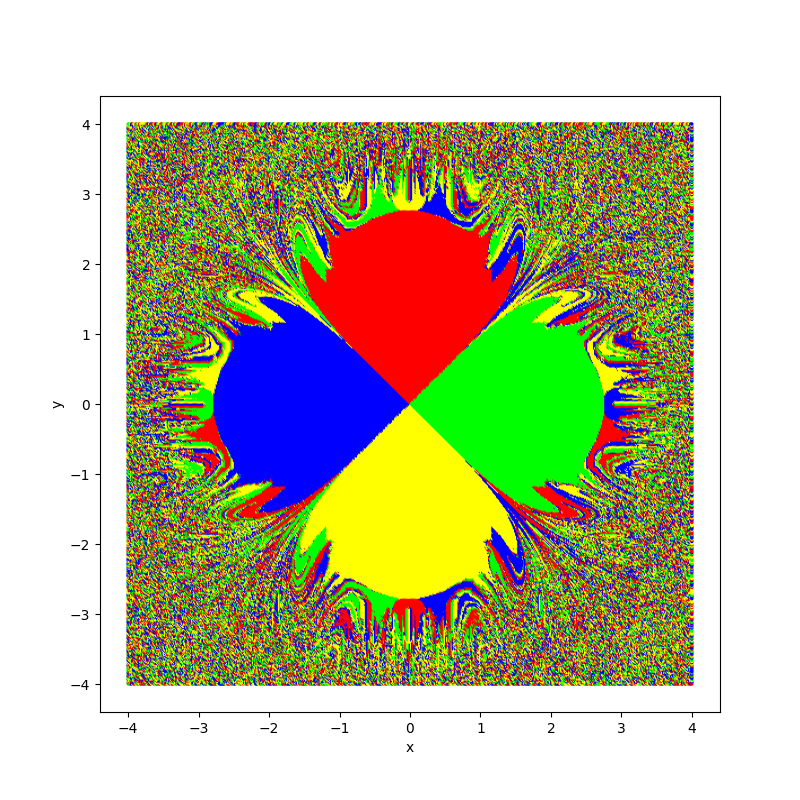

In [111]:
fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
ax.scatter(starting_x_y_pairs[:,0], starting_x_y_pairs[:,1], c=clist, s=2)
ax.set_xlabel('x')
ax.set_ylabel('y')

# ax.set_xlim(x_min,x_max)
# ax.set_ylim(y_min,y_max)



In [115]:
fig.savefig('basins_xy.png', dpi=500)